# Hierarchical mergers of binary black holes
## Group 6
| Student | Registration number |
|---------|---------------------|
| Bellavia Gabriele | 2160133 |
| Belli Luigi | 2152859 |
| Lera Margherita | 2142875 |
| Maida Giovanni Andrea | 2159404 |


## Introduction

A binary black hole can form via close encounters of black holes in a dense
stellar environment, such as a nuclear star cluster, a globular cluster or a young star cluster. In this
case, the two black holes may be single objects at birth, and pair up dynamically at some point in
their “life”. When two stellar-born black holes merge via gravitational wave emission, their merger
remnant is called **second-generation** black hole. If this binary black hole pairs and merges again, it gives birth to a **third-generation** black hole, and so on.
In this way, repeated black hole mergers in star clusters can give birth to hierarchical chains
of mergers, leading to the formation of more and more massive black holes.


## Goal of the project

The goal of the project is to understand the differences between hierarchical binary black hole mergers in three different types of star clusters, by looking at a set of simulated binary black holes. We proceed by following these two steps:

1. Plot and compare the main properties of hierarchical black holes in the different star clusters.
2. Run some simple machine learning algorithm to figure out what features have the highest impact on the fate of a binary black hole in the three different kinds of star clusters.

## Kinds of clusters

We analyze data from dynamical pairing simulations obtained for three types of host clusters:
- Young star clusters (__YSCs__) have ages typically under 100 million years (Myr), with total mass between $10^2$ and $10^4 M_{\odot}$
- Globular star clusters (__GCs__) are more ancient with ages of 10-12 billion years (Gyr), with total mass spanning $10^4$ to $10^6 M_{\odot}$
- Nuclear star clusters (__NSCs__) are the biggest with a total mass of the cluster between $10^6$ and $10^8 M_{\odot}. $

For each type of cluster simulations are performed across a range of metallicities, from near zero to Sun-like metallicity. Metallicity should affect strongly the faith of BBHs starting from the progenitors. In fact, in high metallicity environments massive stars experience strong stellar winds and lose more mass before collapsing resulting in smaller BHs ($20-30 M_{\odot}$), while lower metallicity leads to massive BHs up to $100 M_{\odot}$ or more. The range of metallicities is:

`0.0002, 0.0004, 0.0008, 0.0012, 0.0016, 0.002,  0.004,  0.006,  0.008,  0.012, 0.016,  0.02`

## Dataset construction

The data is pre-processed so that each system that appears in it is made at least by two first generation black holes. To better handle the data, we grouped in a single dataframe (one for each cluster type) all the data for every metallicity value, keeping this as a feature column. Since the algorithm used to generate the data resets the ID numbering at each iteration, we modified the ID column in order to have an unique ID matching all BBHs that belong to the same merge chain.

Hence, the dataset is composed of the following features:

| ID | M1 | M2 | S1 | S2 | t_pair | t_elapsed | kick | Mrem | Srem | esca_v | Mcluster | gen | Z |
|----|----|----|----|----|--------|-----------|------|------|------|--------|----------|-----|---|

- **ID** : Identifier of the system, it allows to track how a black hole evolves with time
- **M1** : Mass of the Primary black hole, expressed in solar masses $M_{\odot}$, it corresponds to the mass of the remnant of the previous generation system
- **M2** : Mass of the secondary object, expressed in solar masses $M_{\odot}$, it is drawn from this interval:  $[3, M1]  M_{\odot}$
- **S1** : Primary spin, it corresponds to the dimensionless spin magnitude of the primary black hole, perpendicular to the orbital plane
- **S2** : same as **S1** but for the secondary object
- **t_pair** : Time needed for two objects to pair up, expressed in $Myr$
- **t_elapsed**: Time passed since the start of the simulation, expressed in $Myr$
- **kick** : Magnitude of the relativistic kick that the merger remnant receives at birth, expressed in $\frac{km}{s}$
- **Mrem** : Mass of the remnant , expressed in solar masses $M_{\odot}$
- **Srem** : Adimensional spin of the remnant as in **S1** and **S2**
- **esca_v** : Escape velocity of each cluster, expressed in $\frac{km}{s}$
- **Mcluster** : Total mass of the host cluster, expressed in solar masses $M_{\odot}$
- **gen** : Generation of the remnant
- **Z** : Metallicity of the cluster
---

In [1]:
# Import necessary packages

import funky
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.animation as animation
from matplotlib import colors
from matplotlib.scale import FuncScale
from IPython import display 
from matplotlib.patches import Rectangle, ConnectionPatch
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay
import warnings

warnings.filterwarnings('ignore')
np.set_printoptions(formatter={'float_kind':"{:.2f}".format})
%matplotlib inline

##  Step 1 : First overview of the data

In the following, we present the distributions of the most relevant quantities for each host cluster, and analyze how these evolve with increasing generations in order to identify any emerging correlations, and further investigate them.

In [2]:
def update(gen):
    data_ysc = x1[x1.gen == gen]
    data_gc = x2[x2.gen == gen]
    data_nsc = x3[x3.gen == gen]

    funky.hist1d(ax[0], data_ysc.M1, data_gc.M1, data_nsc.M1, 3, 1e4, 'log', 'log', 'Primary Mass $(M_{\\odot})$', False)
    ax[0].set_ylim(1,2e5)
    ax[0].set_title(f'Primary mass distribution, generation:{gen}')
    funky.hist1d(ax[1], data_ysc.M2, data_gc.M2, data_nsc.M2, 2, 9e3, 'log', 'log', 'Secondary Mass $(M_{\\odot})$', False)
    ax[1].set_ylim(1,2e5)
    ax[1].set_title(f'Secondary mass distribution, generation:{gen}')
    funky.hist1d(ax[2], data_ysc.S1, data_gc.S1, data_nsc.S1, -0.01, 1.01, 'linear', 'log', 'Primary Spin', False)
    ax[2].set_ylim(1,2e5)
    ax[2].set_title(f'Primary spin distribution, generation:{gen}')
    funky.hist1d(ax[3], data_ysc.S2, data_gc.S2, data_nsc.S2, -0.01, 1.01, 'linear', 'log', 'Secondary Spin', False)
    ax[3].set_ylim(1,2e5)
    ax[3].set_title(f'Secondary spin distribution, generation:{gen}')
    plt.suptitle(f'Generation: {gen}',weight='bold')
    plt.tight_layout()

x1 = funky.extractor('ysc')
x2 = funky.extractor('gc')
x3 = funky.extractor('nsc')

fig, ax = plt.subplots(2,2, figsize=(12, 10))
ax = ax.flatten()  # Flatten the array of axes

ani = animation.FuncAnimation(fig, update, frames=np.arange(2, x3.gen.max()+1),interval=1000, repeat=True)

video = ani.to_html5_video()
html = display.HTML(video) 
  
# draw the animation 
display.display(html) 
plt.close() 

In the upper panels we can see the distributions of the primary and secondary masses, and how they evolve with generations.

We see at first glance the most important differences between hierarchical black holes in the three types of clusters: young star clusters hardly reach the third generation with less than $100$ objects reaching this phase. This is due to peculiar characteristics of YSCs: sparse (dynamical pairing is inefficient), short lifetime (YSCs evaporates in $100$ $Myrs$) and lower mass, hence lower escape velocity. 
GCs manage to get until the sixth generation while NSCs, thanks to the high density and higher escape velocity, host hierarchical black holes until generation $12$.

M2 distribution mimics the one of M1 with a longer tail torwards lower masses.
 
In the lower panels it is displayed the dimensionless spin of primary and secondary objects, defined as 
$ S_i = c \bar{L}_i / Gm_{i}^{2}$, and initially drawn from a Maxwellian distribution. 

For the spin of the primary object, in the lower-left panel, we see that kinds of host clusters differ in the initial distribution:
- YSCs' distribution has one initial peak in $\sim 0.7$.
- GCs and NSCs show a double peak distribution $\sim 0.4$ and $\sim 0.7$.

With passing of generations, peaks shift towards $1.0$, according to how the dimensionless spin of the remnant is drawn from numerical relativity formulas. 

Instead, the spin of the secondary object, in the lower-right panel, shows different peaks at $\sim 0.2$ and $\sim 0.7$. Unlike the primary object, whose spin is preserved across generations, the secondary object's spin does not evolve significantly over time. This is because the spin of the secondary component is drawn from the distribution of first generation BHs if its mass is lower than the maximum mass of the first generation BHs, whereas if it is higher, it is drawn from the distribution of the nth generation.

In [3]:
def update(gen):
    data_ysc = x1[x1.gen == gen]
    data_gc = x2[x2.gen == gen]
    data_nsc = x3[x3.gen == gen]

    funky.hist1d(ax[0], data_ysc.Mrem, data_gc.Mrem, data_nsc.Mrem, 3, 1e5, 'log', 'log', 'Mass of the Remnant $(M_{\\odot})$', False)
    ax[0].set_ylim(1e0,2e5)
    ax[0].get_legend().remove()
    ax[0].set_title(f'Remnant mass distribution, generation:{gen}')
    funky.hist1d(ax[1], data_ysc.Srem, data_gc.Srem, data_nsc.Srem, -0.01,1.01 , 'linear', 'log', 'Spin of the Remnant', False)
    ax[1].set_ylim(1e0,1e6)
    ax[1].get_legend().remove()
    ax[1].set_title(f'Remnant spin distribution, generation:{gen}')
    funky.hist1d(ax[2], data_ysc.kick, data_gc.kick, data_nsc.kick, 0,1000 , 'linear', 'log', 'Gravitational kick of the remnant ($\\frac{km}{s}$)', False)
    ax[2].set_ylim(1,1e5)
    ax[2].axvline(data_ysc.esca_v.mean(), color='blue', label='$\\bar{v}_{esc, YSC}$')
    ax[2].errorbar(data_ysc.esca_v.mean(), 1e4, xerr=data_ysc.esca_v.std(), ecolor='blue',elinewidth=1000, alpha=0.2)
    ax[2].axvline(data_gc.esca_v.mean(), color='orange', label='$\\bar{v}_{esc, GC}$')
    ax[2].errorbar(data_gc.esca_v.mean(), 2e4, xerr=data_gc.esca_v.std(), ecolor='orange',elinewidth=1000, alpha=0.2)
    ax[2].axvline(data_nsc.esca_v.mean(), color='green', label='$\\bar{v}_{esc, NSC}$')
    ax[2].errorbar(data_nsc.esca_v.mean(), 3e4, xerr=data_nsc.esca_v.std(), ecolor='green', elinewidth=1000, alpha=0.2)
    ax[2].get_legend().remove()
    ax[2].set_title(f'Kick velocities distribution, generation:{gen}')

    funky.hist1d(ax[3], data_ysc.Mcluster, data_gc.Mcluster, data_nsc.Mcluster, 1, 1e8, 'log', 'log', 'Cluster Mass ($M_{\\odot}$)', False)
    
    ax[3].set_ylim(1e0,1e6)
    ax[3].get_legend().remove()
    ax[3].set_title(f'Cluster mass distribution, generation:{gen}')
    #ax[2].legend(loc="center", bbox_to_anchor=(0.5,-0.2), ncols=6)
    handles, labels = ax[2].get_legend_handles_labels()
    plt.suptitle(f'Generation:  {gen}',weight='bold')
    fig.legend(handles=handles, labels=labels,loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=9)
    plt.subplots_adjust(hspace=0.3)
    
fig, ax = plt.subplots(2,2, figsize=(10, 10))
ax = ax.flatten()  # Flatten the array of axes

ani = animation.FuncAnimation(fig, update, frames=np.arange(2, x3.gen.max()),interval=1000, repeat=True)
#ani.save('prova.mp4', writer='ffmpeg')
video = ani.to_html5_video()
html = display.HTML(video) 
  
# draw the animation 
display.display(html) 
plt.close() 

Here, we present additional distributions of quantities related to the remnant and its host cluster.

In the upper panels the distribution of the remnant mass and spin are shown. At a glance, we observe a general increase in mass, following a trend $M_{rem} \simeq M_1 + M_2$, hence the peak of the nth generation tends to cluster around the maximum mass of the previous one. Moreover, we observe that the spins shift in the range of $\sim0.7-0.9$, according to Mapelli et al. This influences the number of nth generation mergers. In fact, larger spins are associated with stronger relativistic kicks, hence we can see that the number of mergers decreases as the spin shifts. This is more evident for GCs and YSCs which have smaller escape velocities.

In the lower-left panel, we show the distribution of kick-induced velocities, with the mean escape velocity of host cluster, and the standard deviation overlaid. We see a significant number of objects that exceed the escape velocity of the cluster, meaning that they could get away from the system.

In the lower-right, the distribution of the three types of host clusters' mass is shown.  More massive star clusters are more likely to host higher-generations BBHs due to higher escape velocities and higher interaction rate.


    




### Covariance Matrices, Feature Correlations

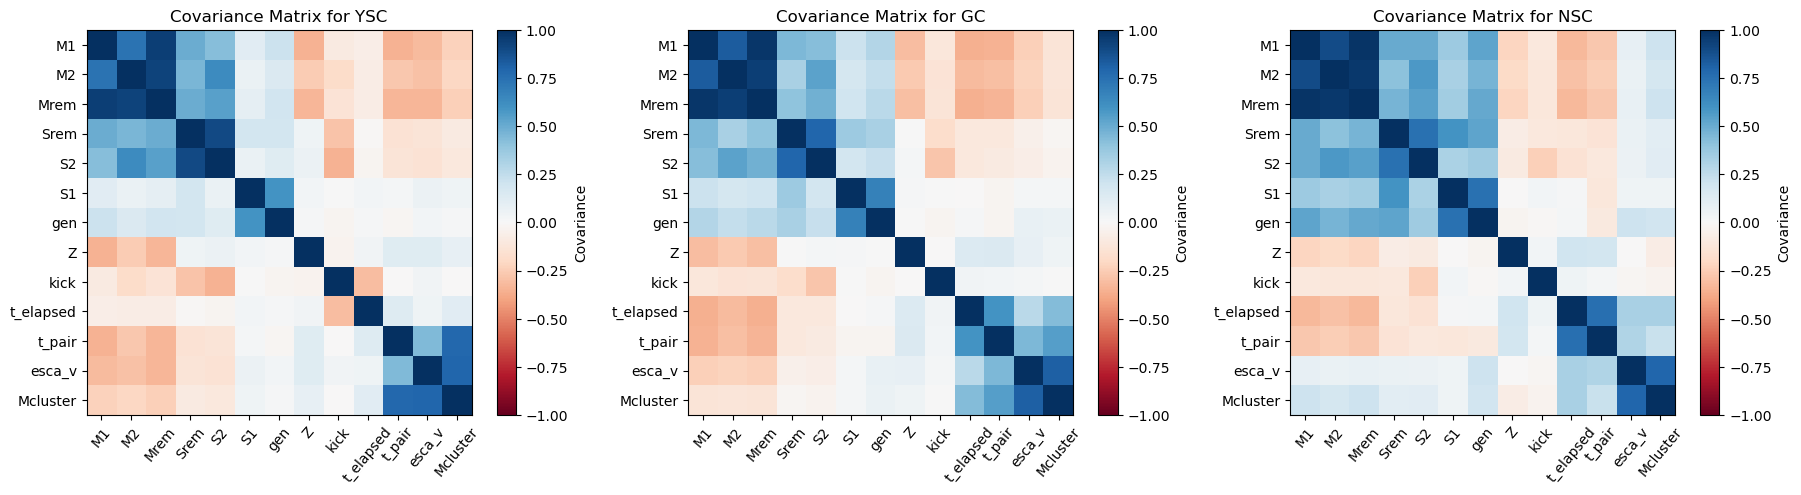

In [5]:
fig, ax = plt.subplots(1,3,figsize=(22,5))
plt.sca(ax[0])
funky.fast_covariance_matrix('ysc','RdBu')
plt.sca(ax[1])
funky.fast_covariance_matrix('gc', 'RdBu')
plt.sca(ax[2])
funky.fast_covariance_matrix('nsc', 'RdBu')
plt.show()

Here are displayed the covariance matrix for each type of cluster in order to have a first glance on relationships between variables and how these change in different astrophysics environments.
In particular we see that the masses $M_1$ and $M_2$ are highly correlated to $M_{rem}$, and also the generation is correlated to the remnant mass especially in clusters that host BH of higher generations. 
According to the theory we see that the metallicity $Z$ is inversely correlated to the masses, as we already said, the metallicity increases the mass loss due to stellar winds during phases preceding the death of the star. The time necessary for an object to pair respectively $t_{pair}$ is negatively correlated to the masses since higher time to pair usually means that the objects are not massive enough to do so. 

In [4]:
data_ysc=funky.extractor('ysc')
data_gc=funky.extractor('gc')
data_nsc=funky.extractor('nsc')

### Primary Mass vs. Secondary Mass


The first relation we study is the one between the mass of the primary and the mass of the secondary BHs. 
We observe that, by construction, the secondary object is always less massive than the first.
We also immediately see that the dataset referring to YSCs has fewer massive objects compared to the others. This is because by definition YSCs are less dense clusters than the others, so they will have less stars, and also they will fail to form high-mass, high-generation mergers. 
As we could have expected, we don't observe a correlation between the two features.

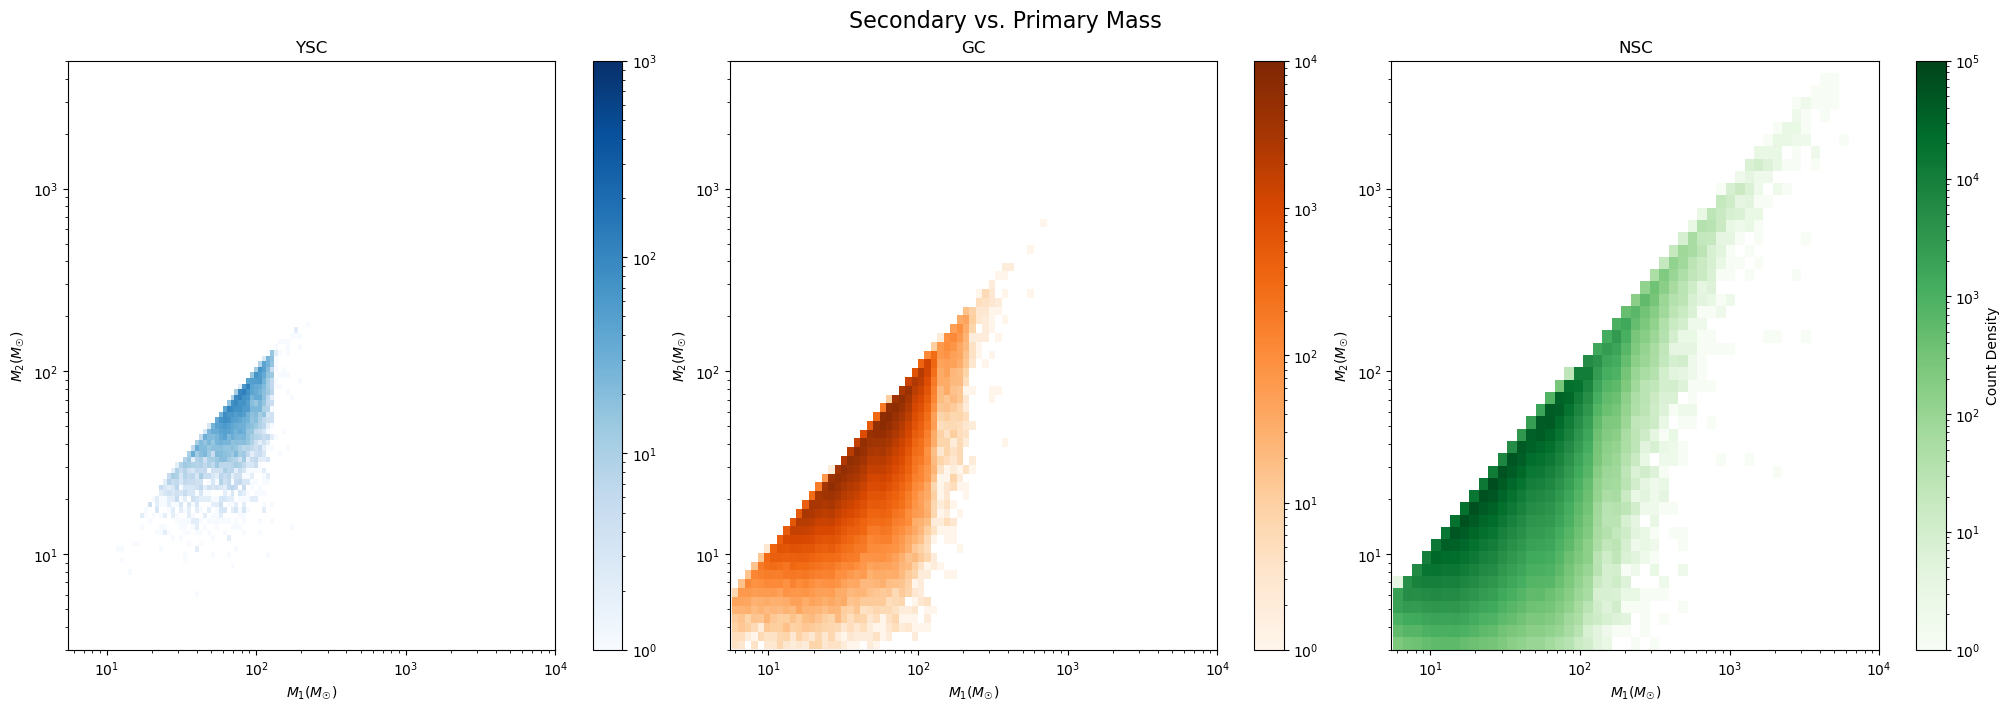

In [5]:
fig,ax=plt.subplots(1,3,figsize=(20,7), layout='constrained')
fig.suptitle("Secondary vs. Primary Mass", fontsize=16)
plt.sca(ax[0])

hist_ysc=funky.hist2dgraph(data_ysc.M1,data_ysc.M2,50,50,'YSC',u'$M_1 (M_\u2609)$',u'$M_2 (M_\u2609)$',1,1e3,scale_x='log',scale_y='log')
plt.ylim(3e0,5e3)
plt.xlim(5.5e0,1e4)
fig.colorbar(hist_ysc[3], ax=ax[0])

plt.sca(ax[1])
hist_gc=funky.hist2dgraph(data_gc.M1,data_gc.M2,50,50,'GC',u'$M_1 (M_\u2609)$',u'$M_2 (M_\u2609)$',1,1e4,scale_x='log',scale_y='log',cmap='Oranges')
plt.ylim(3e0,5e3)
plt.xlim(5.5e0,1e4)
fig.colorbar(hist_gc[3], ax=ax[1])

plt.sca(ax[2])
hist_nsc=funky.hist2dgraph(data_nsc.M1,data_nsc.M2,50,50,'NSC',u'$M_1 (M_\u2609)$',u'$M_2 (M_\u2609)$',1,1e5,scale_x='log',scale_y='log',cmap='Greens')
plt.ylim(3e0,5e3)
plt.xlim(5.5e0,1e4)
fig.colorbar(hist_nsc[3], ax=ax[2], label="Count Density")
plt.show()

### Remnant Mass vs. Primary Mass

In the following plot, we study the correlation between the mass of the remnant and the mass of the primary BH.
We see that the mass of the primary object is, trivially, never higher than the result of the merge.
We observe a strong linear correlation, that indicates that the outcome of the merge is strongly dependent on the primary object when the simulation computes the merge.
Comparing the three different clusters, we observe (in agreement with the graphs above) that in NSCs there are higher-mass mergers, while in YSCs we are able to create only a limited range in mass of objects.

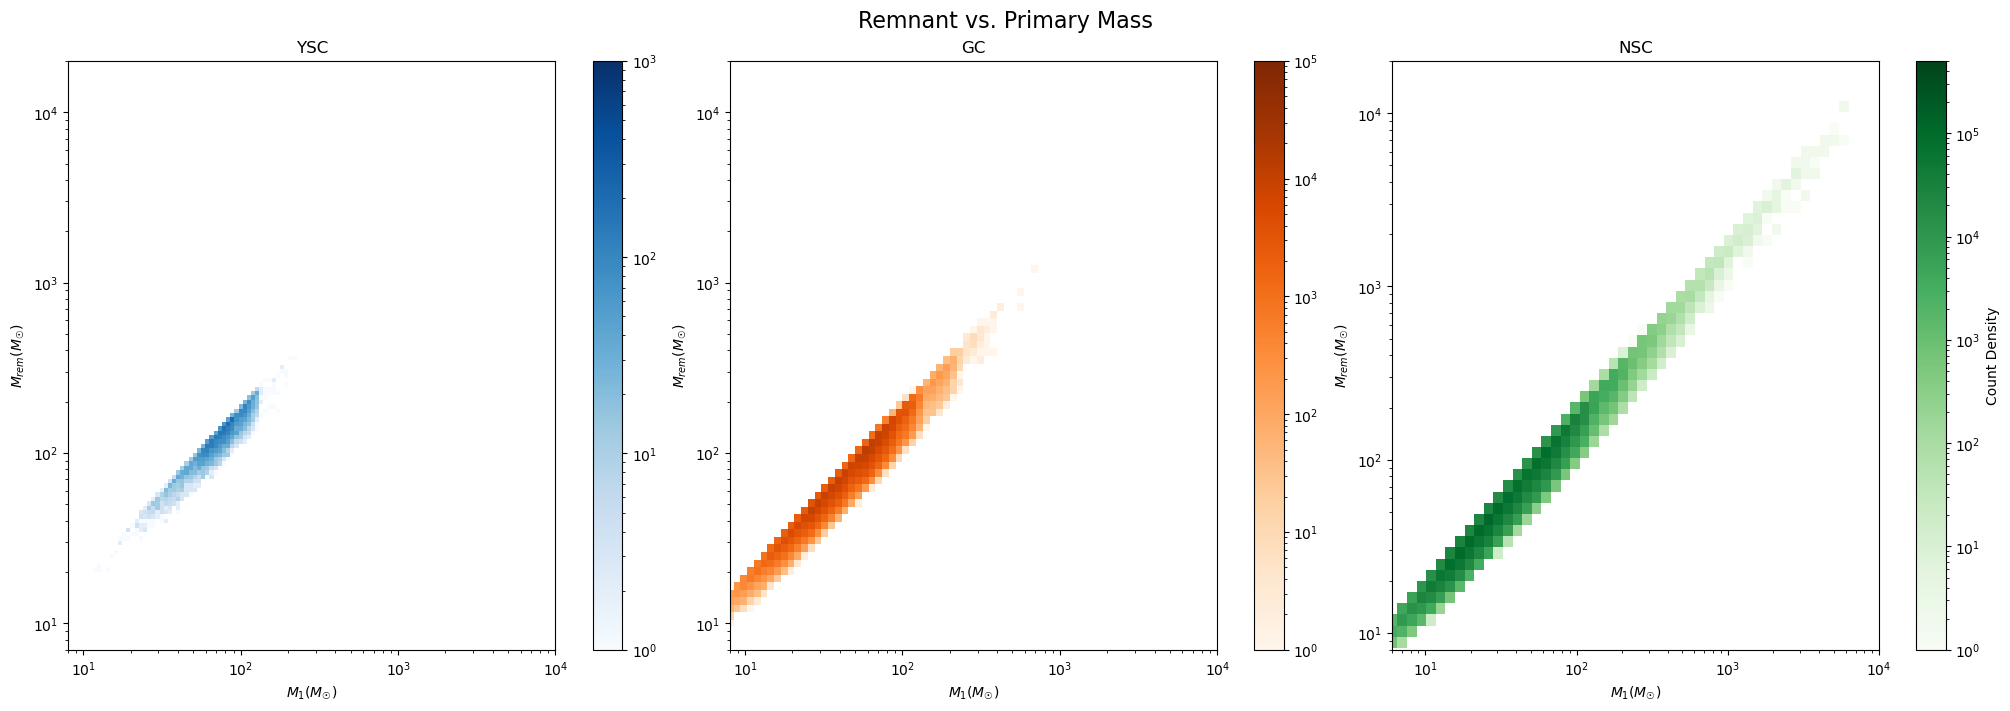

In [6]:
fig,ax=plt.subplots(1,3,figsize=(20,7), layout='constrained')
fig.suptitle("Remnant vs. Primary Mass", fontsize=16)
plt.sca(ax[0])

hist_ysc=funky.hist2dgraph(data_ysc.M1,data_ysc.Mrem,50,50,'YSC',u'$M_1 (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 1e3, 'log','log')
plt.ylim(7e0,2e4)
plt.xlim(8e0,1e4)
fig.colorbar(hist_ysc[3], ax=ax[0])
plt.sca(ax[1])
hist_gc=funky.hist2dgraph(data_gc.M1,data_gc.Mrem,50,50,'GC',u'$M_1 (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 1e5, 'log','log',cmap='Oranges')
plt.ylim(7e0,2e4)
plt.xlim(8e0,1e4)
fig.colorbar(hist_gc[3], ax=ax[1])
plt.sca(ax[2])
hist_nsc=funky.hist2dgraph(data_nsc.M1,data_nsc.Mrem,50,50,'NSC',u'$M_1 (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 5e5, 'log','log',cmap='Greens')
plt.ylim(8e0,2e4)
plt.xlim(6e0,1e4)
fig.colorbar(hist_nsc[3], ax=ax[2], label="Count Density")
plt.show()

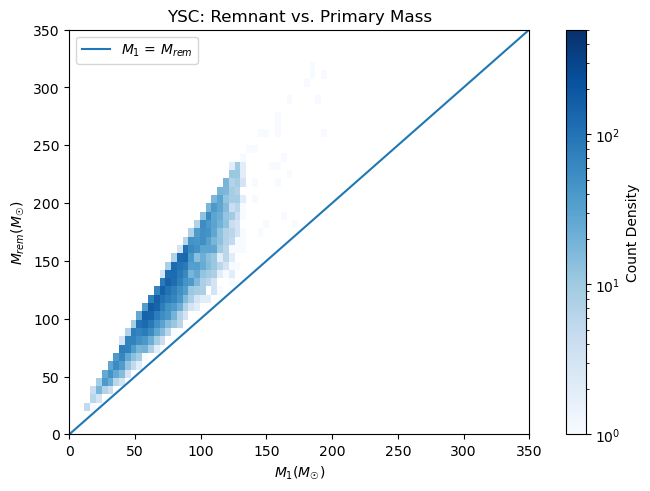

In [7]:
fig, ax=plt.subplots(layout='constrained')
hist_ysc=funky.hist2dgraph(data_ysc.M1,data_ysc.Mrem,50,50,'YSC: Remnant vs. Primary Mass',u'$M_1 (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 5e2)
plt.colorbar(hist_ysc[3], ax=ax, label="Count Density")
ax.set_xlim(0,350)
ax.set_ylim(0,350)
x=np.arange(0,350)
y=np.arange(0,350)
y2=2*x
ax.plot(x,y, label=u'$M_1$ = $M_{rem}$')
ax.legend()
plt.show()

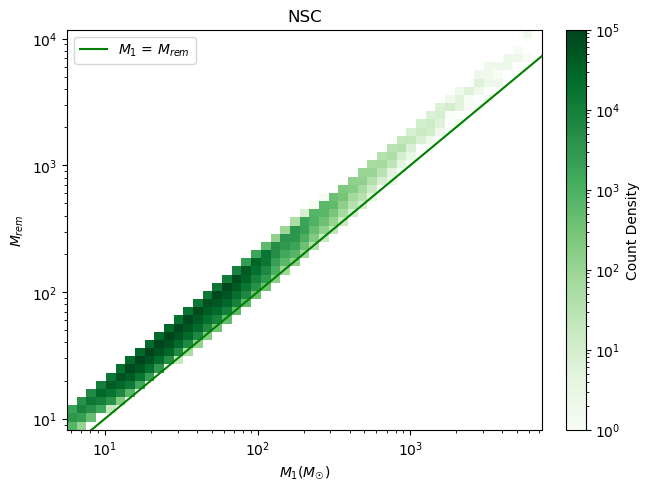

In [8]:
fig,ax=plt.subplots(layout='constrained')
x=data_nsc.M1
y=data_nsc.Mrem
vmin=1
vmax=1e5
nybin=50
nxbin=50
ybin= np.logspace(np.log10(y.min()),np.log10(y.max()),nybin)
xbin= np.logspace(np.log10(x.min()),np.log10(x.max()),nxbin)

hist= ax.hist2d(x,y,bins=(xbin,ybin), cmap='Greens', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_title('NSC')
ax.set_xlabel(u'$M_1 (M_\u2609)$')
ax.set_ylabel(u'$M_{rem}$')
ax.set_xscale('log')
ax.set_yscale('log')
x=np.arange(0,int(10e4))
y=x
ax.plot(x,y, label=u'$M_1$ = $M_{rem}$',c='green')
ax.legend()


fig.colorbar(hist[3], ax=ax, label="Count Density",)
plt.show()

### Remnant mass vs. Secondary Mass


We quickly show for comparison the distribution of objects using as features the secondary mass and the remnant mass.
We get for all three distributions that the remnant mass is always higher than the secondary mass, in agreement with what we find for the primary mass.
This time, while we do not observe a correlation as strong as before between the two features, there is still a condensed region along the diagonal.

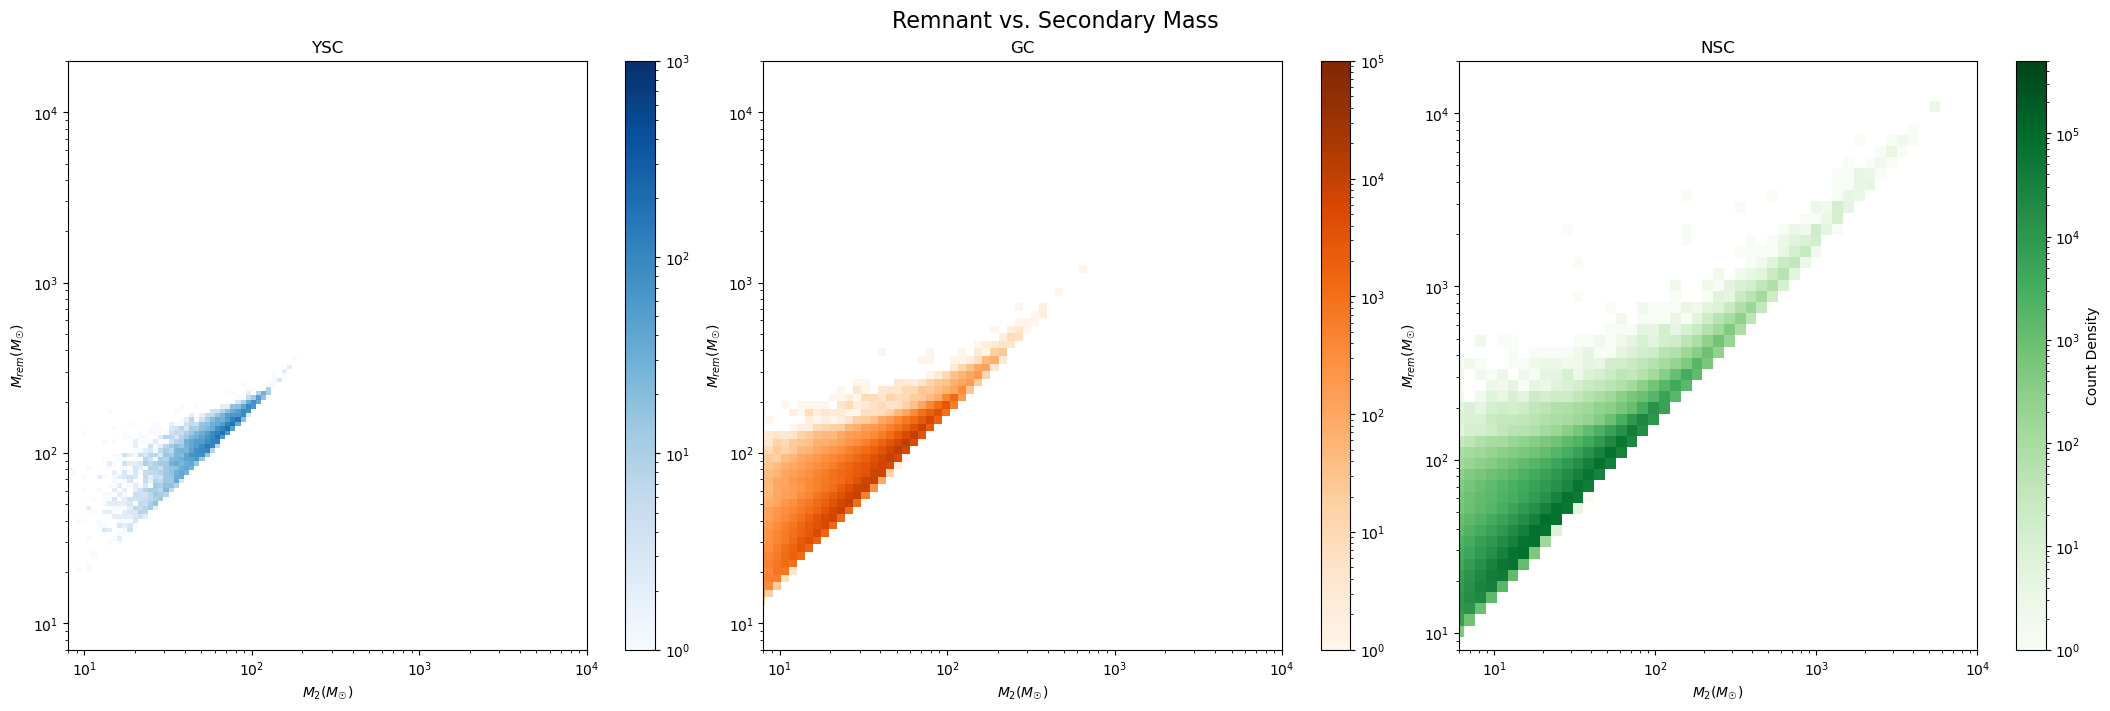

In [9]:
fig,ax=plt.subplots(1,3,figsize=(21,7), layout='constrained')
fig.suptitle("Remnant vs. Secondary Mass", fontsize=16)
plt.sca(ax[0])

hist_ysc=funky.hist2dgraph(data_ysc.M2,data_ysc.Mrem,50,50,'YSC',u'$M_2 (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 1e3, 'log','log')
plt.ylim(7e0,2e4)
plt.xlim(8e0,1e4)
fig.colorbar(hist_ysc[3], ax=ax[0])
plt.sca(ax[1])
hist_gc=funky.hist2dgraph(data_gc.M2,data_gc.Mrem,50,50,'GC',u'$M_2 (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 1e5, 'log','log',cmap='Oranges')
plt.ylim(7e0,2e4)
plt.xlim(8e0,1e4)
fig.colorbar(hist_gc[3], ax=ax[1])
plt.sca(ax[2])
hist_nsc=funky.hist2dgraph(data_nsc.M2,data_nsc.Mrem,50,50,'NSC',u'$M_2 (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 5e5, 'log','log',cmap='Greens')
plt.ylim(8e0,2e4)
plt.xlim(6e0,1e4)

fig.colorbar(hist_nsc[3], ax=ax[2], label="Count Density")
plt.show()

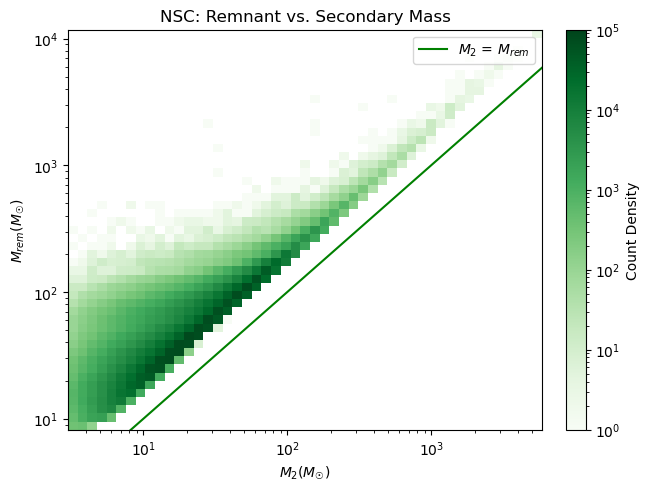

In [10]:
fig,ax=plt.subplots(layout='constrained')
x=data_nsc.M2
y=data_nsc.Mrem
vmin=1
vmax=1e5
nybin=50
nxbin=50
ybin= np.logspace(np.log10(y.min()),np.log10(y.max()),nybin)
xbin= np.logspace(np.log10(x.min()),np.log10(x.max()),nxbin)

hist= ax.hist2d(x,y,bins=(xbin,ybin), cmap='Greens', norm=colors.LogNorm(vmin=vmin, vmax=vmax))
ax.set_title('NSC: Remnant vs. Secondary Mass')
ax.set_xlabel(u'$M_2 (M_\u2609)$')
ax.set_ylabel(u'$M_{rem} (M_\u2609)$')
ax.set_xscale('log')
ax.set_yscale('log')
fig.colorbar(hist[3], ax=ax, label="Count Density")
x2=range(0,int(1e5))
y2=x2
ax.plot(x2,y2, label=u'$M_2$ = $M_{rem}$',color='green')
ax.legend()
plt.show()

### Remnant Mass vs. Total Pre-Merge Mass

We take as a new feature the sum of primary and secondary mass and we plot it against the remnant mass. We then compare it with the relation we found between the remnant and the primary mass. 
We observe an even stronger correlation 1:1 than the one we found for the primary mass, indicating that the remnant mass is almost equal to the sum of the masses of the merged BHs. 


In [11]:
for data in [data_ysc,data_gc,data_nsc]:
    data['Msum']=data.M1 + data.M2
data_nsc.head()

,ID,M1,M2,S1,S2,t_pair,t_elapsed,kick,Mrem,Srem,esca_v,Mcluster,gen,Z,max_gen,DV,Msum
0,5.012,69.094208,57.670705,0.711019,0.128699,21.438521,69.894253,140.429345,118.529632,0.824918,100.738543,1.367033e+06,2,0.012,2,-39.690801,126.764913
1,7.012,38.063741,27.883363,0.734012,0.237416,51.203516,251.268351,297.785549,61.471238,0.847818,115.854632,1.910889e+06,2,0.012,2,-181.930917,65.947104
2,10.012,24.989444,16.916495,0.725597,0.109035,48.154724,1346.827550,139.837902,39.195086,0.839305,75.571979,7.917869e+05,2,0.012,2,-64.265922,41.905938
3,14.012,14.042051,11.606979,0.732162,0.061596,47.724524,568.277129,1251.734444,24.000409,0.822013,89.027333,7.019308e+05,2,0.012,2,-1162.707111,25.649030
4,15.012,16.814667,15.241542,0.717129,0.162880,20.372879,195.462327,572.048708,29.959652,0.823334,108.498143,7.039505e+05,2,0.012,2,-463.550565,32.056208


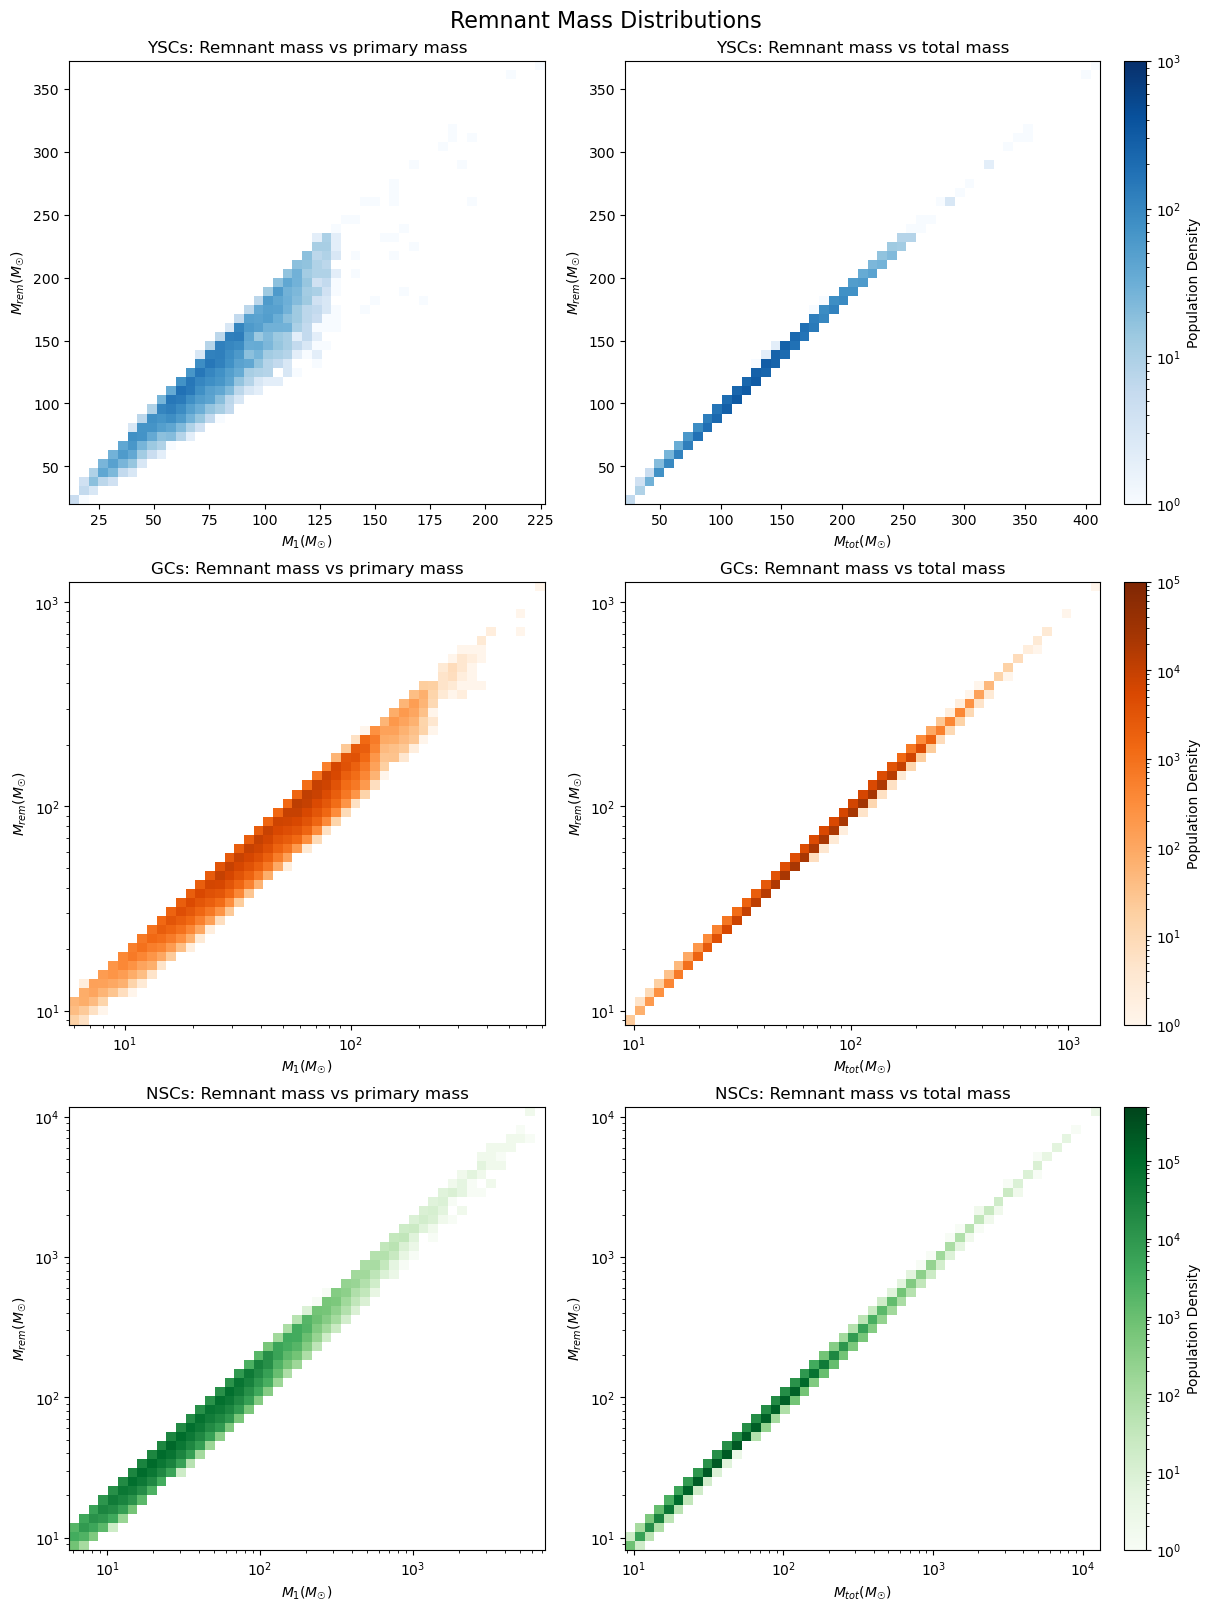

In [12]:
fig, ax = plt.subplots(3,2,figsize=(12,16), layout='constrained')
fig.suptitle("Remnant Mass Distributions", fontsize=16)
plt.sca(ax[0,0])
hist = funky.hist2dgraph(data_ysc.M1,data_ysc.Mrem,50,50,'YSCs: Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 1e3)
plt.sca(ax[0,1])
hist2 = funky.hist2dgraph(data_ysc.Msum,data_ysc.Mrem,50,50,'YSCs: Remnant mass vs total mass',u'$M_{tot} (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 1e3)
fig.colorbar(hist2[3], ax=ax[0,1],label='Population Density')


plt.sca(ax[1,0])
hist = funky.hist2dgraph(data_gc.M1,data_gc.Mrem,50,50,'GCs: Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 1e5, 'log','log',cmap='Oranges')
plt.sca(ax[1,1])
hist2 = funky.hist2dgraph(data_gc.Msum,data_gc.Mrem,50,50,'GCs: Remnant mass vs total mass',u'$M_{tot} (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 1e5, 'log','log',cmap='Oranges')
fig.colorbar(hist2[3], ax=ax[1,1],label='Population Density')

plt.sca(ax[2,0])
hist = funky.hist2dgraph(data_nsc.M1,data_nsc.Mrem,50,50,'NSCs: Remnant mass vs primary mass',u'$M_1 (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 5e5, 'log','log', cmap='Greens')
plt.sca(ax[2,1])
hist2 = funky.hist2dgraph(data_nsc.Msum,data_nsc.Mrem,50,50,'NSCs: Remnant mass vs total mass',u'$M_{tot} (M_\u2609)$', u'$M_{rem} (M_\u2609)$', 1, 5e5, 'log','log', cmap='Greens')
fig.colorbar(hist2[3],  ax=ax[2,1],label='Population Density')

plt.show()

### Remnant Mass vs. Metallicity

Even if metallicity has no strong impact on the nth generation remnant masses, the metallicity of the progenitor BHs could leave an imprint on the mass spectrum of first generation and consequently on the nth generation mergers. In fact, we observe a slightily descending trend, especially in YSCs: the higher the metallicity, the smaller the mass of the remnant is. This makes sense as in high-metallicity clusters, stellar winds are more effective and limit the formation of high-mass BHs.

In [13]:
data_ysc_a=data_ysc[data_ysc['gen']==2]
data_gc_a=data_gc[data_gc['gen']==2]
data_nsc_a=data_nsc[data_nsc['gen']==2]


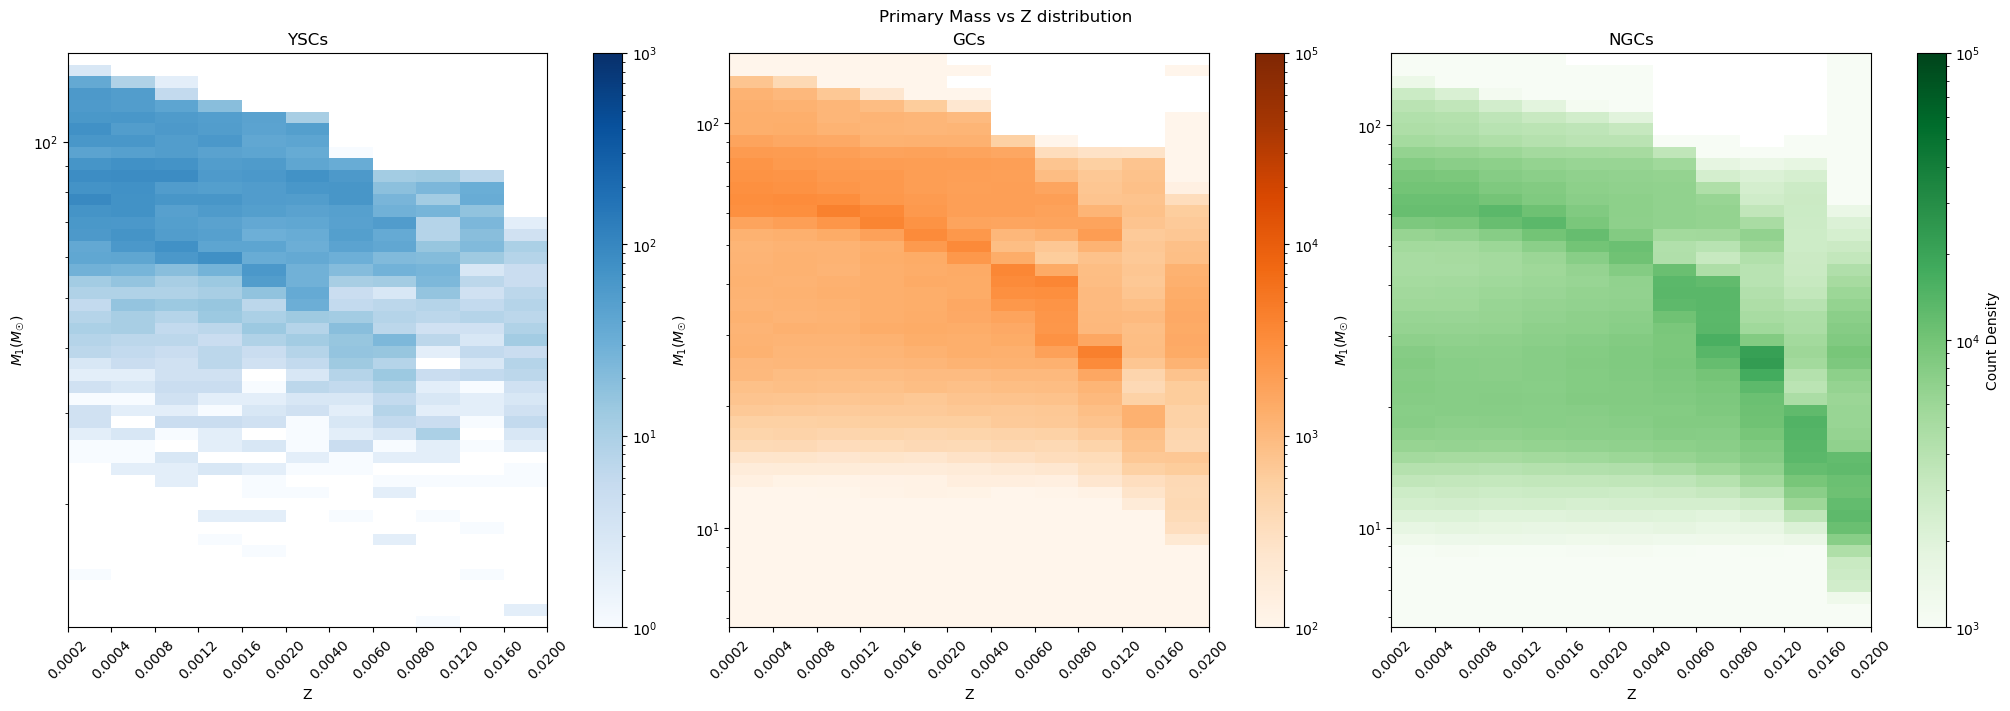

In [14]:
fig,ax=plt.subplots(1,3,figsize=(20,7), layout='constrained')
fig.suptitle('Primary Mass vs Z distribution')

def forward(x):
    return np.interp(x, z_bins, np.arange(len(z_bins)))
def inverse(x):
    return np.interp(x, np.arange(len(z_bins)), z_bins)

z_bins = np.array([2e-4, 4e-4, 8e-4, 12e-4, 16e-4, 2e-3, 4e-3, 6e-3, 8e-3, 12e-3, 16e-3, 2e-2])

plt.sca(ax[0])
Rem_bins = np.logspace(np.log10(data_ysc_a.M1.min()),np.log10(data_ysc_a.M1.max()),50) 
# Create the FuncScale object correctly
scale = FuncScale(ax[0].xaxis, (forward, inverse))
hist1 = plt.hist2d(data_ysc_a.Z,data_ysc_a.M1, bins=(z_bins,Rem_bins), cmap="Blues", norm=colors.LogNorm( vmin=1, vmax=1e3))

# Apply the scale to the x-axis
ax[0].set_xscale('function', functions=(forward, inverse))
# Set custom tick positions and labels
plt.xticks(z_bins, rotation=45)
# Set y-axis scale
plt.yscale("log")
plt.title('YSCs')
plt.xlabel(u'Z')
plt.ylabel(u'$M_{1} (M_\u2609$)')

plt.sca(ax[1])
Rem_bins = np.logspace(np.log10(data_gc_a.M1.min()),np.log10(data_gc_a.M1.max()),50) 
# Create the FuncScale object correctly
scale = FuncScale(ax[1].xaxis, (forward, inverse))
hist2 = plt.hist2d(data_gc_a.Z,data_gc_a.M1, bins=(z_bins,Rem_bins), cmap="Oranges", norm=colors.LogNorm( vmin=1e2, vmax=1e5))

# Apply the scale to the x-axis
ax[1].set_xscale('function', functions=(forward, inverse))
# Set custom tick positions and labels
plt.xticks(z_bins, rotation=45)
# Set y-axis scale
plt.yscale("log")
plt.title('GCs')
plt.xlabel(u'Z')
plt.ylabel(u'$M_{1} (M_\u2609$)')

plt.sca(ax[2])
Rem_bins = np.logspace(np.log10(data_nsc_a.M1.min()),np.log10(data_nsc_a.M1.max()),50) 
# Create the FuncScale object correctly
scale = FuncScale(ax[2].xaxis, (forward, inverse))
hist3  = plt.hist2d(data_nsc_a.Z,data_nsc_a.M1, bins=(z_bins,Rem_bins), cmap="Greens", norm=colors.LogNorm(vmin=1e3, vmax=1e5))

# Apply the scale to the x-axis
ax[2].set_xscale('function', functions=(forward, inverse))
# Set custom tick positions and labels
plt.xticks(z_bins, rotation=45)
# Set y-axis scale
plt.yscale("log")
plt.title('NGCs')
plt.xlabel(u'Z')
plt.ylabel(u'$M_{1} (M_\u2609$)')

fig.colorbar(hist1[3], ax=ax[0])
fig.colorbar(hist2[3], ax=ax[1])
fig.colorbar(hist3[3], ax=ax[2], label="Count Density")

plt.show()

### Gen vs Primary spin

As observed in the covariance matrix, the generation is influenced by the spin of the primary object. This is because larger spins are associated with stronger relativistic kicks compared to smaller spin magnitudes. Hence, in clusters with smaller escape velocities, mergers are more likely to escape, while in clusters with larger escape velocities, mergers are more likely to be retained, leading to more interaction opportunities and then a higher number of mergers.

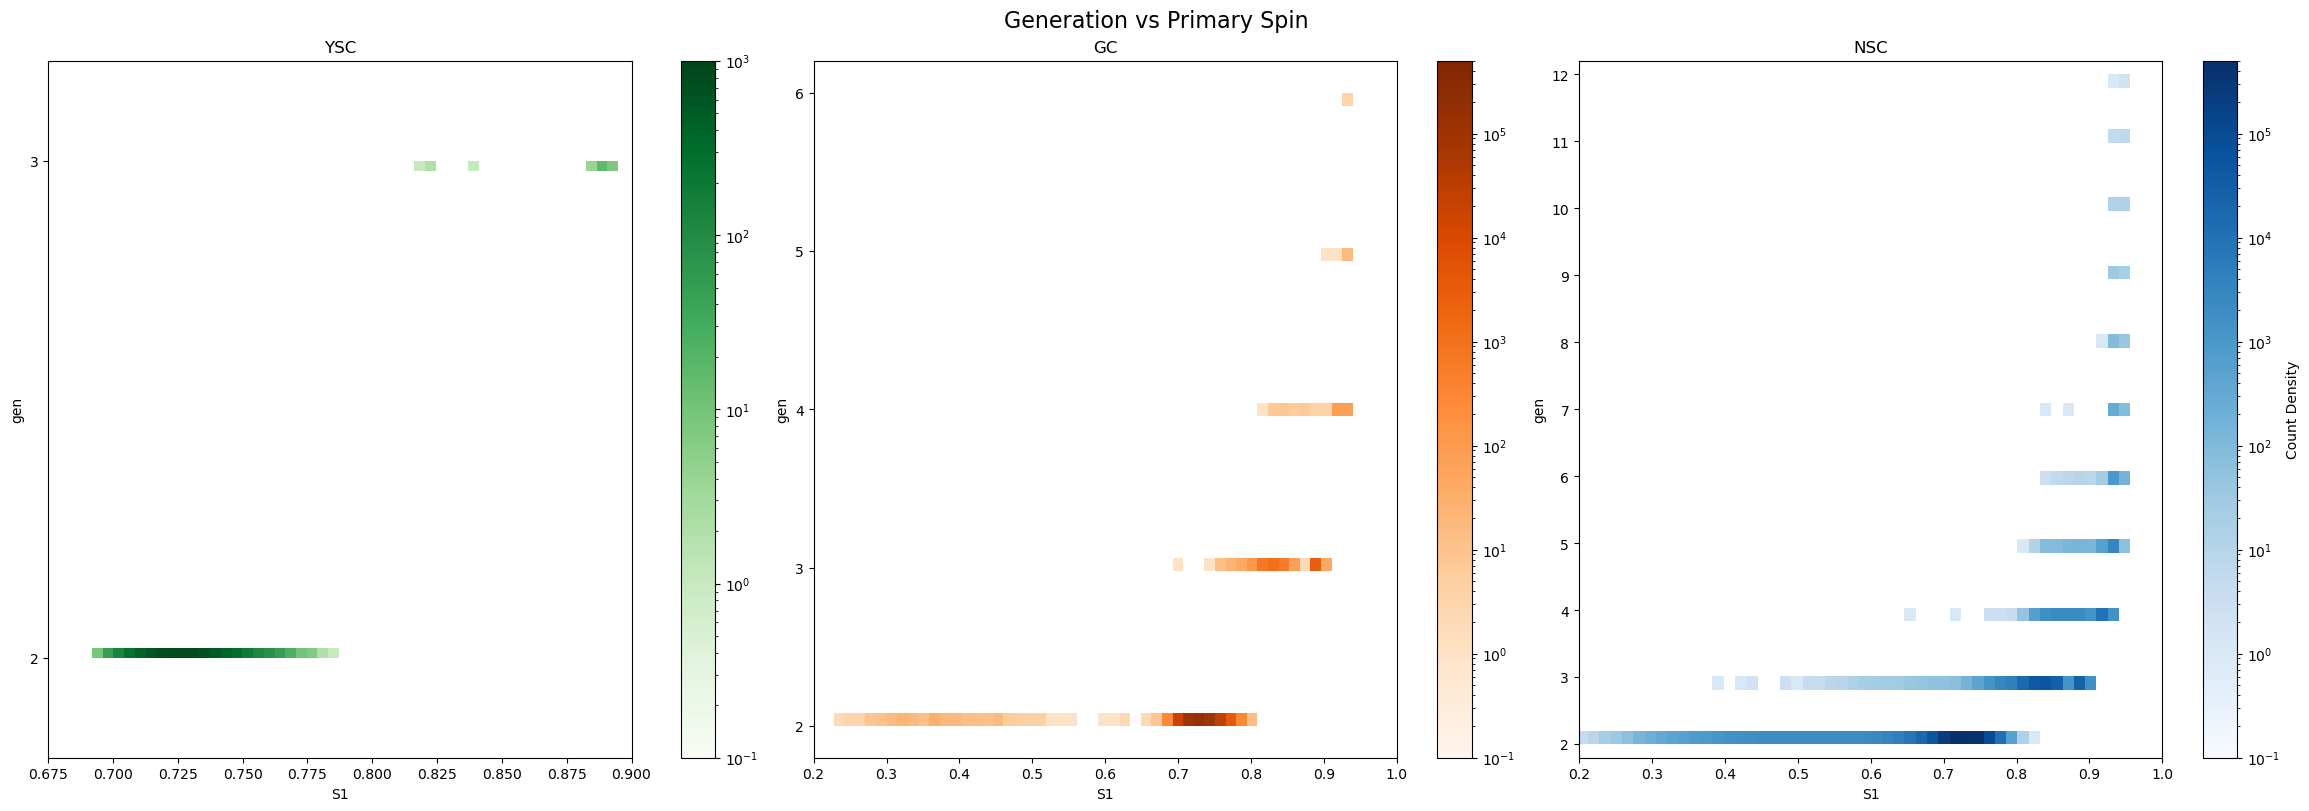

In [15]:
fig,ax=plt.subplots(1,3,figsize=(23,8), layout='constrained')
fig.suptitle('Generation vs Primary Spin', fontsize=16)
plt.sca(ax[0])

hist_ysc=funky.hist2dgraph(data_ysc.S1,data_ysc.gen,50,50,'YSC','S1', u'gen', 0.1, 1e3,'linear','linear',cmap='Greens')
plt.ylim(1.8,3.2)
plt.xlim(0.675,0.9)
fig.colorbar(hist_ysc[3], ax=ax[0])
plt.yticks(ticks=data_ysc['gen'].unique())

plt.sca(ax[1])
hist_gc=funky.hist2dgraph(data_gc.S1,data_gc.gen,50,50,'GC',u'S1', u'gen', 0.1, 5e5,'linear','linear',cmap='Oranges')
plt.ylim(1.8,6.2)
plt.xlim(0.2,1)
fig.colorbar(hist_gc[3], ax=ax[1])
plt.yticks(ticks=data_gc['gen'].unique())

plt.sca(ax[2])
hist_nsc=funky.hist2dgraph(data_nsc.S1,data_nsc.gen,50,50,'NSC','S1', u'gen', 0.1, 5e5,'linear','linear')
plt.ylim(1.8,12.2)
plt.xlim(0.2,1)
fig.colorbar(hist_nsc[3], ax=ax[2], label="Count Density")
plt.yticks(ticks=data_nsc['gen'].unique())

plt.show()

### Remant vs. Secondary Spin


We also investigate the correlation between the spin of the remnant and the spin of the BHs based on the correlation shown in the covariance matrix. We find a linear correlation which is more visible in NSCs. We decide to investigate further this feature in the last part of the study.

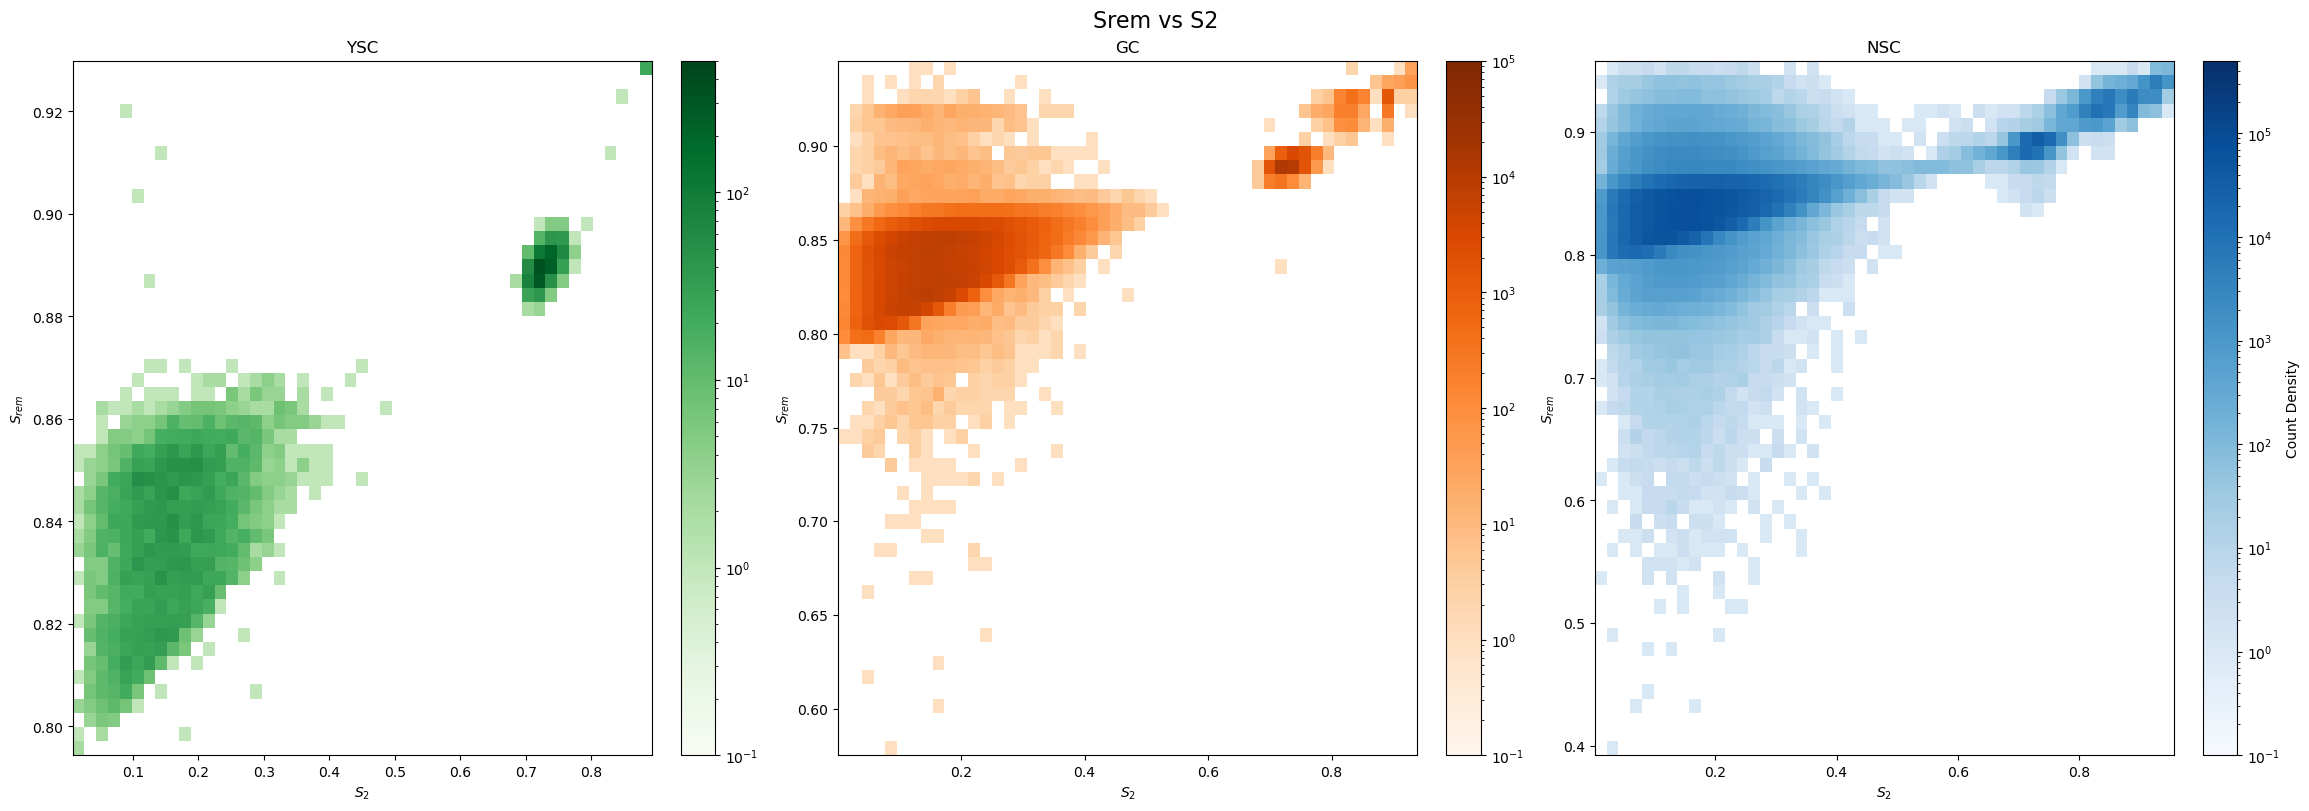

In [16]:
fig,ax=plt.subplots(1,3,figsize=(23,8), layout='constrained')
fig.suptitle("Srem vs S2", fontsize=16)
plt.sca(ax[0])

hist_ysc=funky.hist2dgraph(data_ysc.S2,data_ysc.Srem,50,50,'YSC',u'$S_{2}$', u'$S_{rem}$', 0.1, 5e2,cmap='Greens')

fig.colorbar(hist_ysc[3], ax=ax[0])
plt.sca(ax[1])
hist_gc=funky.hist2dgraph(data_gc.S2,data_gc.Srem,50,50,'GC',u'$S_{2}$', u'$S_{rem}$', 0.1, 1e5,cmap='Oranges')

fig.colorbar(hist_gc[3], ax=ax[1])
plt.sca(ax[2])
hist_nsc=funky.hist2dgraph(data_nsc.S2,data_nsc.Srem,50,50,'NSC',u'$S_{2}$', u'$S_{rem}$', 0.1, 5e5)


fig.colorbar(hist_nsc[3], ax=ax[2], label="Count Density")
plt.show()

## Step 2: Random Forests
The targets of our analysis are the **maximum generation** reached by a BBH system, and the evolution of the **remnant spin**, since we already know that the remnant mass is $0.9 (M_1 + M_2)$ of the previous generation.

## Maximum generations
First thing first, we check if it is possible to predict the maximum generation reached by each BBH from the initial conditions - i.e. from the data of the first generation of each BBH.

To do so we employ the RandomForestClassifier class from the scikit-learn python package. Since we know there are fewer and fewer samples for greater generations, we group together all generations above the third one in a single class. Furthermore, we define a new feature in the dataset called `DV` which is $v_{escape} - v_{kick}$: we know that if the latter is greater than the former the remnant BH is ejected from its cluster, thus being unable to evolve further, hence we expect it to be important.

We begin the analysis with the NSCs, since they are in much larger number, and we know they reach older generations.

In [17]:
# Helper function to better define the method's target classes

def classes(gen):
    if gen > 3: return 2
    return gen - 2  # In this way we should be able to correctly cycle through colors later on

In [18]:
# selecting initial conditions and removing undesired features from the dataframe

first_gen = data_nsc[data_nsc['gen'] == 2]
dumped_features = ['ID', 'gen', 'max_gen']

# splitting data in training and test set
x_train, x_test, y_train, y_test = train_test_split((train_feats := first_gen.drop(columns=dumped_features)), first_gen['max_gen'].transform(classes), test_size=0.2)

# Running the RFC algorithm
forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)

# Printing results
print('Confusion Matrix\n', ['Max gen 2', 'Max gen 3', 'Max gen above 3'], '\n', confusion_matrix(y_test, forest.predict(x_test)))

Confusion Matrix
 ['Max gen 2', 'Max gen 3', 'Max gen above 3'] 
 [[479331    326     24]
 [     0  20399  11708]
 [     0   1433   2725]]


From the confusion matrix we can clearly appreciate that the forest is almost perfectly able to classify BBHs that stop at the second generation ($\sim 370$ samples of this group are misclassified into the other ones, and no samples of older generations are labeled as this one), but it is not as accurate in distinguishing the remaining ones from one other.

By the importance graph below, we infer that the main and practically only interesting feature to do the job is the $v_{escape} - v_{kick}$ feature (hence we may attribute part of the uncertainty to those remnants with a low value of the feature), hinting that is not possible to predict the maximum generation from the initial conditions only.

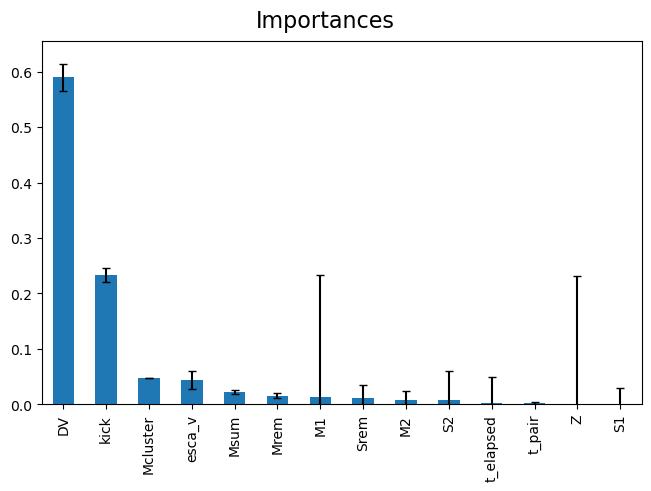

In [19]:
# Plotting importances

fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(0)
plt.show()

#### GC & YSC
We expect the model to behave in the same way for GCs and YSCs, so we just run the forest prediction, and calculate the confusion matrix over the corresponding whole datasets.

In [20]:
# GCs

gc_first_gen = data_gc[data_gc['gen'] == 2]
gc_test = gc_first_gen.drop(columns=dumped_features)


print(gc_first_gen.groupby('max_gen').size(), '\n\nConfusion Matrix\n', ['Max gen 2', 'Max gen 3', 'Max gen above 3'])
print(confusion_matrix((target_gc := gc_first_gen['max_gen'].transform(classes)), forest.predict(gc_test)))

max_gen
2    422018
3      5500
4       178
5        15
6         3
dtype: int64 

Confusion Matrix
 ['Max gen 2', 'Max gen 3', 'Max gen above 3']
[[421949     62      7]
 [     0   4155   1345]
 [     0    120     76]]


In [21]:
# YSCs

ysc_first_gen = data_ysc[data_ysc['gen'] == 2]
ysc_test = ysc_first_gen.drop(columns=dumped_features)


print(ysc_first_gen.groupby('max_gen').size(), '\n\nConfusion Matrix\n', ['Max gen 2', 'Max gen 3'])
print(confusion_matrix((target_ysc := ysc_first_gen['max_gen'].transform(classes)), forest.predict(ysc_test)))

max_gen
2    7143
3      32
dtype: int64 

Confusion Matrix
 ['Max gen 2', 'Max gen 3']
[[6221  492  430]
 [   0   32    0]
 [   0    0    0]]


### Decision Boundaries
To visualize the accuracy of the forest we plot the decision boundaries of the two most important features in the feature space calculated by the method, along with the test points. The plot clearly shows the struggle of trying to classify points different from the escaped ones.

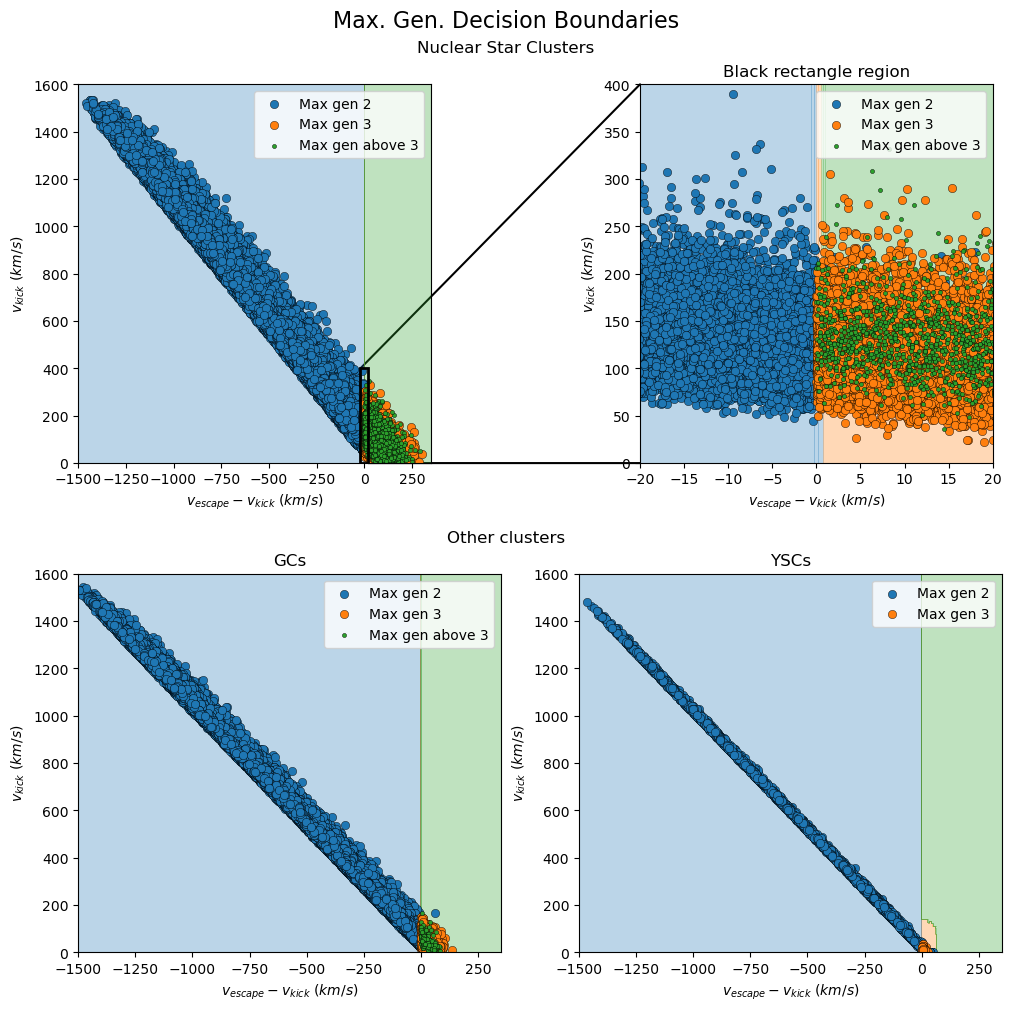

In [22]:
# Forest fit over the two most important features
forest.fit(x_train[list(importances.index)[:2]], y_train)

# Initialize figure spaces
fig = plt.figure(figsize=(10,10), layout='constrained')
fig.suptitle('Max. Gen. Decision Boundaries', fontsize=16)

sfigs = fig.subfigures(2,1)
sfigs[0].suptitle('Nuclear Star Clusters')
sfigs[1].suptitle('Other clusters')

ax0 = sfigs[0].subplots(1,2)
ax1 = sfigs[1].subplots(1,2)

# NSCs test set
for target, color, label, marker in zip(y_test.unique(), ['tab:blue', 'tab:orange', 'tab:green'], ['Max gen 2', 'Max gen 3', 'Max gen above 3'], ['o', 'o', '.']):
    idx = y_test[y_test == target].index
    ax0[0].scatter(x_test['DV'][idx], x_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)
    ax0[1].scatter(x_test['DV'][idx], x_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)

# GCs
for target, color, label, marker in zip(target_gc.unique(), ['tab:blue', 'tab:orange', 'tab:green'], ['Max gen 2', 'Max gen 3', 'Max gen above 3'], ['o', 'o', '.']):
    idx = target_gc[target_gc == target].index
    ax1[0].scatter(gc_test['DV'][idx], gc_test['kick'][idx], marker=marker, c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)

#YSCs
for target, color, label in zip(target_ysc.unique(), ['tab:blue', 'tab:orange'], ['Max gen 2', 'Max gen 3']):
    idx = target_ysc[target_ysc == target].index
    ax1[1].scatter(ysc_test['DV'][idx], ysc_test['kick'][idx], c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)

# Decorations
ax0[0].add_patch(Rectangle([-20, 0], 40, 400, color='k', lw=2, fill=False, zorder=2.03))
ax0[0].add_patch(ConnectionPatch([-20, 400], [0, 1], 'data', 'axes fraction', axesA=ax0[0], axesB=ax0[1], lw=1.5))
ax0[0].add_patch(ConnectionPatch([20, 0], [0, 0], 'data', 'axes fraction', axesA=ax0[0], axesB=ax0[1], lw=1.5))

ax0[1].set_xlim(-20, 20)
ax0[1].set_ylim(0,400)
ax0[1].set_title('Black rectangle region')

ax1[0].set_title('GCs')
ax1[1].set_title('YSCs')

# Initialize contourf workspace
feat_1, feat_2 = np.meshgrid(np.linspace(x_train['DV'].min() - 100, x_train['DV'].max() + 100, 1000), np.linspace(x_train['kick'].min() - 100, x_train['kick'].max() + 100, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)

# Common decorations and contourf
for i, Ax in enumerate(fig.get_axes()):
    Ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=colors.ListedColormap(['tab:blue', 'tab:orange', 'tab:green']))
    Ax.set_xlabel('$v_{escape} - v_{kick}$ $(km/s)$')
    Ax.set_ylabel('$v_{kick}$ $(km/s)$')
    Ax.legend(loc='upper right')
    if i != 1:
        Ax.set_xlim(-1500, 350)
        Ax.set_ylim(0, 1600)

plt.show()

### Targeted generation
We expect this behaviour to hold for older generations too, to prove this we run the algorithm over a sample of target generations (for the sake of brevity we only show one of them), and set the objective to its possible evolution.

In [23]:
# data preparation
gen_prec = data_nsc[data_nsc['gen'] == 5]
dumped_features = ['ID', 'gen', 'max_gen']
x_train, x_test, y_train, y_test = train_test_split((train_feats := gen_prec.drop(columns=dumped_features)), gen_prec['max_gen'] > 5, test_size=0.2)

# running forest algorithm
forest = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=1758, n_jobs=-1, class_weight='balanced')
forest.fit(x_train, y_train)
print(f'train size: {len(gen_prec)}\ntest size: {len(y_test)}')
print('Score:', forest.score(x_test, y_test))

train size: 4245
test size: 849
Score: 1.0


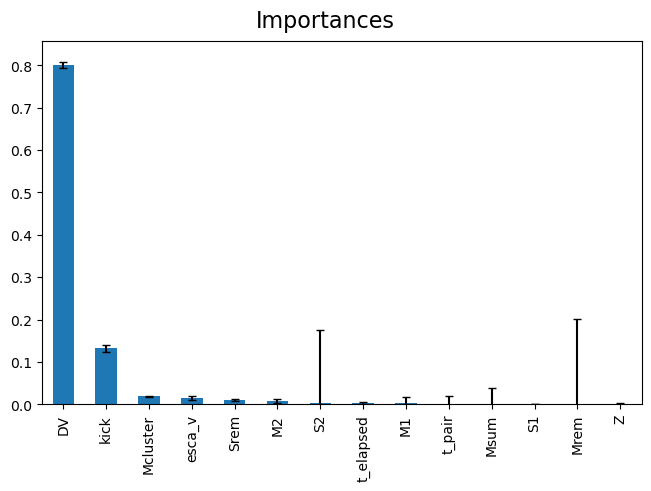

In [24]:
# plot importances

fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

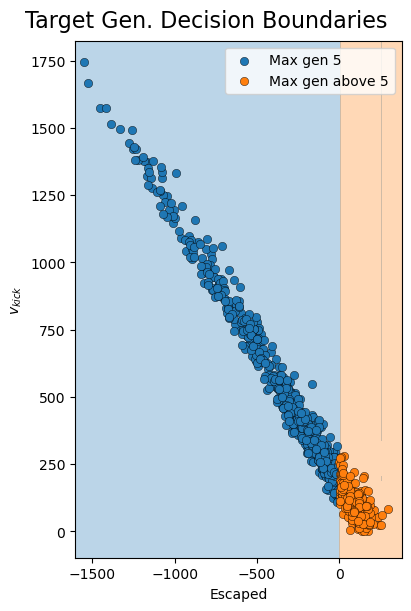

In [25]:
# plot decision boundaries

fig, ax = plt.subplots(figsize=(4,6), layout='constrained')
fig.suptitle('Target Gen. Decision Boundaries', fontsize=16)

forest.fit(x_train[list(importances.index)[:2]], y_train)

feat_1, feat_2 = np.meshgrid(np.linspace(x_train['DV'].min() - 100, x_train['DV'].max() + 100, 1000), np.linspace(x_train['kick'].min() - 100, x_train['kick'].max() + 100, 1000))
lab = forest.predict(np.c_[feat_1.ravel(), feat_2.ravel()])
lab = lab.reshape(feat_1.shape)

ax.contourf(feat_1, feat_2, lab, alpha=.3, cmap=colors.ListedColormap(['tab:blue', 'tab:orange']))
for target, color, label in zip(y_test.unique(), ['tab:blue', 'tab:orange'], ['Max gen 5', 'Max gen above 5']):
    idx = y_test[y_test == target].index
    ax.scatter(x_test['DV'][idx], x_test['kick'][idx], c=color, edgecolors='k', lw=.3, label=label, zorder=2.02)



ax.set_ylabel('$v_{kick}$')
ax.set_xlabel('Escaped')
ax.legend()
plt.show()

## Spin of the Remnant
Since the spin of the remnant is a continuous features, we implement the RandomForestRegressor class instead.

In [26]:
dumped_features = ['ID', 'Srem', 'max_gen', 'DV', 'Mrem']

x_train, x_test, y_train, y_test = train_test_split((train_feats := data_nsc.drop(columns=dumped_features)), data_nsc['Srem'], test_size=0.2)

forest = RandomForestRegressor(n_estimators=10, max_depth=15, random_state=1758, n_jobs=-1)
forest.fit(x_train, y_train)


print(f'train size: {len(y_train)}\ntest size: {len(y_test)}')
print('Score over the test set:', '{:.2f}'.format(forest.score(x_test, y_test)))
print('Score over the GC data:', '{:.2f}'.format(forest.score(data_gc.drop(columns=dumped_features), data_gc['Srem'])))
print('Score over the YSC data:', '{:.2f}'.format(forest.score(data_ysc.drop(columns=dumped_features), data_ysc['Srem'])))

train size: 2230650
test size: 557663
Score over the test set: 0.98
Score over the GC data: 0.97
Score over the YSC data: 0.97


As with the RFC, the algorithm performs well for GCs and YSCs too.

By the importances graph below, and the subsequent decision boundaries graph, we infer that there is a strong relationship between $S_{rem}$ and $S_2$ as discussed in the first part. In fact the former is a complex combination of $S_1$, $S_2$, $M_1$ and $M_2$

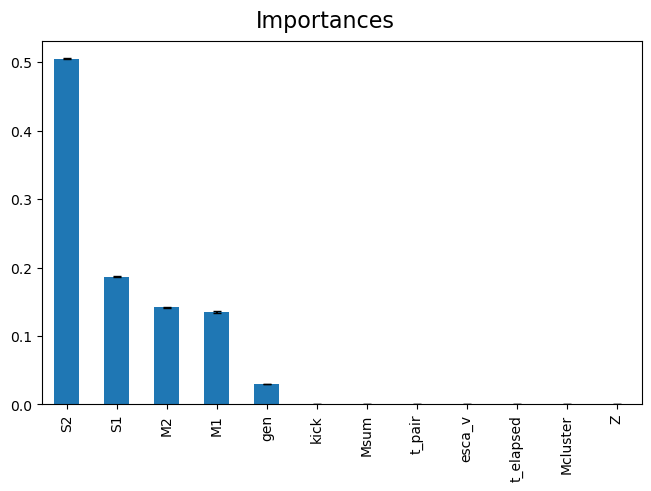

In [27]:
fig, ax = plt.subplots(layout='constrained')
fig.suptitle('Importances', fontsize=16)

importances = pd.Series(forest.feature_importances_, index=list(train_feats)).sort_values(ascending=False)
importances.plot.bar(yerr=np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0), capsize=3, ax=ax)
ax.set_ylim(bottom=0)
plt.show()

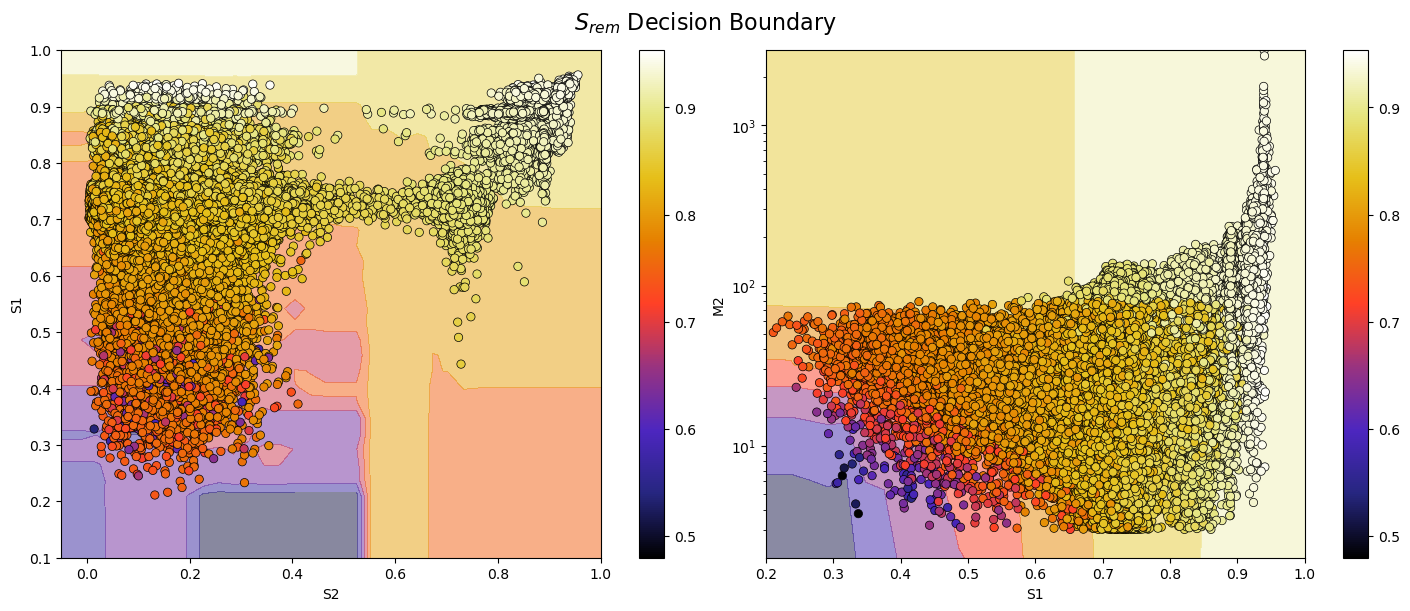

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(14,6), layout='constrained')
fig.suptitle('$S_{rem}$ Decision Boundary', fontsize=16)


forest.fit(x_train[( important_features := list(importances.index[:2]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[0])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[0].set_xlim(-.05, 1)
ax[0].set_ylim(0.1, 1)
fig.colorbar(im)


forest.fit(x_train[( important_features := list(importances.index[[1,2]]) )], y_train)
display = DecisionBoundaryDisplay.from_estimator(forest, x_test[important_features], response_method="predict", alpha=.5, cmap='CMRmap', ax=ax[1])

im = display.ax_.scatter(x_test[important_features[0]], x_test[important_features[1]], edgecolor='k', c=y_test, lw=.5, cmap='CMRmap')
ax[1].set_yscale('log')
ax[1].set_xlim(.2, 1)
fig.colorbar(im)

plt.show()